In [8]:
from collections import namedtuple
import time
import os
import numpy as np
import sys
import torch
from tqdm import tqdm
from dress_code_data import DressCodeDataLoader, DressCodeDataset, DressCodeDatasetAnyDoor
# from utils import sem2onehot
import argparse
from matplotlib import pyplot as plt
import PIL
from torchvision.transforms import ToPILImage,Grayscale,ToTensor

import cv2
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import os
import numpy as np
import json
from typing import List, Tuple
from dress_code_data.labelmap import label_map
from numpy.linalg import lstsq


In [9]:
torch.set_printoptions(threshold=1000)

In [10]:
def test_unpaired(dataloader, model, e, args):
    with tqdm(
        desc="Iteration %d - images extraction" % e,
        unit="it",
        total=len(dataloader.data_loader),
    ) as pbar:
        for step in range(0, len(dataloader.data_loader)):
            inputs = dataloader.next_batch()

            with torch.no_grad():
                image_name = inputs["im_name"]
                cloth_name = inputs["c_name"]
                image = inputs["image"].cuda()
                cloth = inputs["cloth"].cuda()
                cropped_cloth = inputs["im_cloth"].cuda()
                im_head = inputs["im_head"].cuda()
                pose_map = inputs["pose_map"].cuda()
                skeleton = inputs["skeleton"].cuda()
                im_pose = inputs["im_pose"].cuda()
                shape = inputs["shape"].cuda()
                parse_array = inputs["parse_array"].cuda()
                dense_labels = inputs["dense_labels"].cuda()
                dense_uv = inputs["dense_uv"].cuda()

                parse_array = sem2onehot(18, parse_array)

                # model here

def training_loop(dataloader, model, e, args):

    with tqdm(
        desc="Iteration %d - train" % e, unit="it", total=args.display_count
    ) as pbar:
        for step in range(0, args.display_count):
            inputs = dataloader.next_batch()

            image_name = inputs["im_name"]
            cloth_name = inputs["c_name"]
            image = inputs["image"].cuda()
            cloth = inputs["cloth"].cuda()
            cropped_cloth = inputs["im_cloth"].cuda()
            im_head = inputs["im_head"].cuda()
            pose_map = inputs["pose_map"].cuda()
            skeleton = inputs["skeleton"].cuda()
            im_pose = inputs["im_pose"].cuda()
            shape = inputs["shape"].cuda()
            parse_array = inputs["parse_array"].cuda()
            dense_labels = inputs["dense_labels"].cuda()
            dense_uv = inputs["dense_uv"].cuda()

            parse_array = sem2onehot(18, parse_array)

            # model here

            pbar.update()

def main_worker(args):

    # Dataset & Dataloader
    dataset_train = DressCodeDatasetAnyDoor(
        args,
        dataroot_path=args.dataroot,
        phase="train",
        order="paired",
        size=(int(args.height), int(args.width)),
    )

    dataloader_train = torch.utils.data.DataLoader(dataset_train)

    return iter(dataloader_train)

In [11]:
args = argparse.Namespace(batch_size=1, category='all', checkpoint_dir='', data_pairs='{}_pairs', dataroot='/home/ubuntu/mnt/myvolume/DressCode', display_count=1000, epochs=150, exp_name='', height=1024, radius=5, shuffle=True, step=100000, width=768, workers=0)

# Call main worker
sample_it  = main_worker(args)

In [12]:
ref_image = cv2.imread('/home/ubuntu/mnt/myvolume/DressCode/dresses/images/020716_1.jpg')
ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
ref_mask = (ref_image < 255).astype(np.uint8)[:, :, 0]
model_image = cv2.imread('/home/ubuntu/mnt/myvolume/DressCode/dresses/images/020716_0.jpg')
model_image = cv2.cvtColor(model_image, cv2.COLOR_BGR2RGB)


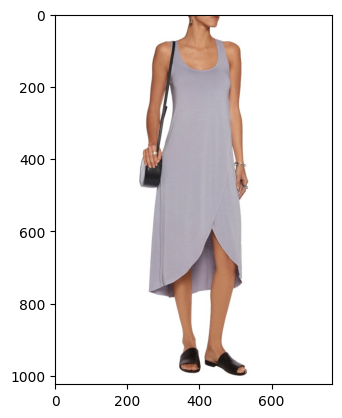

In [13]:
plt.imshow(model_image)
plt.show()

In [14]:
sample = next(sample_it)

In [15]:
sample.keys()

dict_keys(['ref', 'jpg', 'hint', 'extra_sizes', 'tar_box_yyxx_crop', 'time_steps'])

In [9]:
sample["cloth"][0].permute(2,1,0).shape

torch.Size([3, 768, 1024])

torch.Size([1024, 768, 3])


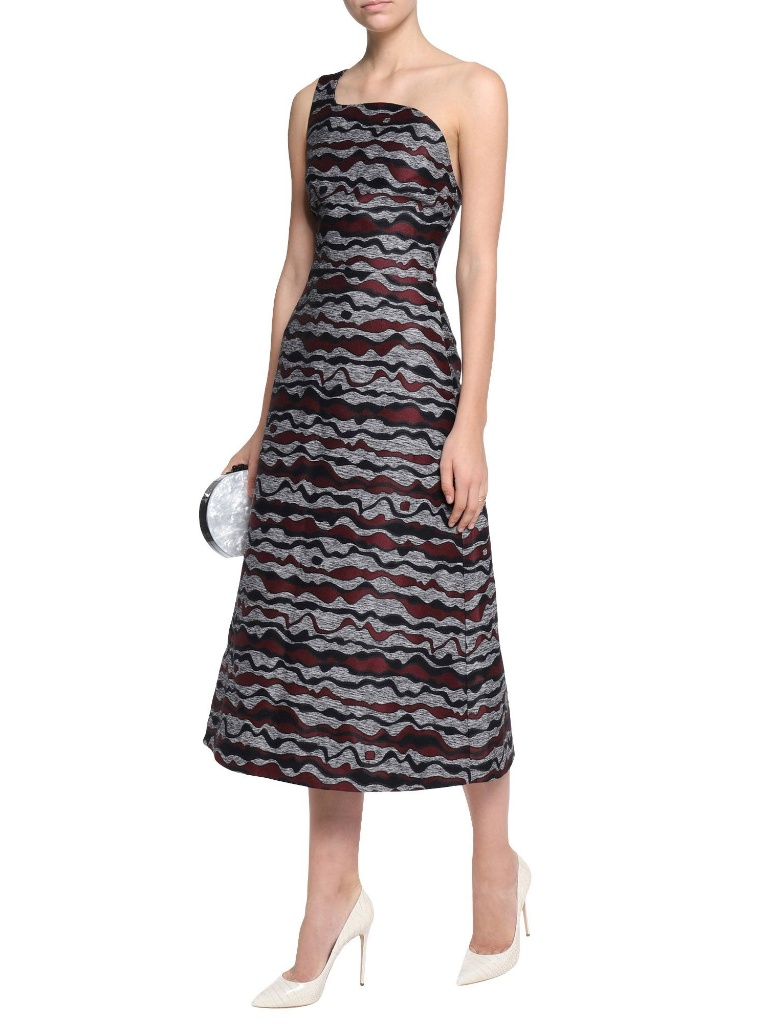

In [15]:
print(sample["model_image"][0].shape)
to_pil_image = ToPILImage()
img = to_pil_image(sample["model_image"][0].permute(2,0,1))

# Display the image
img.show()

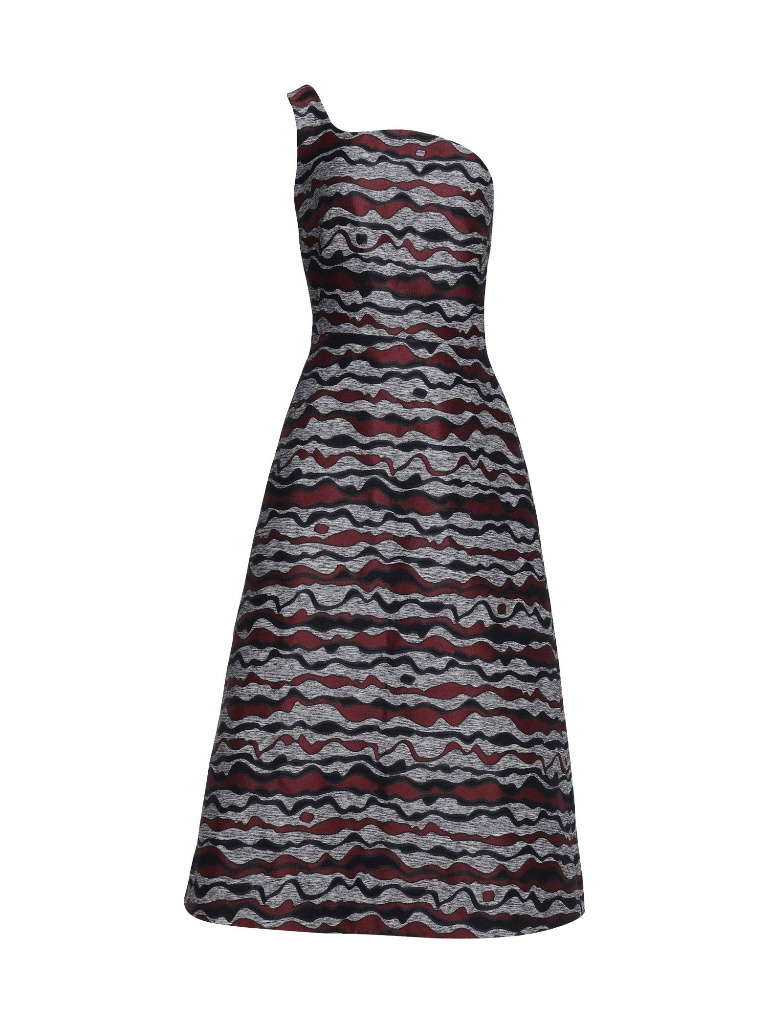

In [11]:
to_pil_image = ToPILImage()
img = to_pil_image(sample["cloth"][0].permute(2,0,1))

# Display the image
img.show()

In [ ]:
to_pil_image = ToPILImage()
img = to_pil_image(sample["cloth"][0])

# Display the image
img.show()

torch.Size([1024, 768])


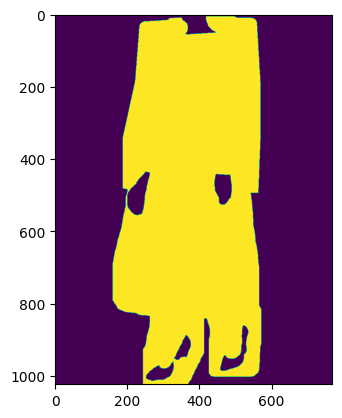

In [14]:
print(sample["model_mask"][0].shape)
plt.imshow(sample["model_mask"][0])
plt.show()

In [15]:
sample["ref_mask"].shape

torch.Size([1, 1024, 768])

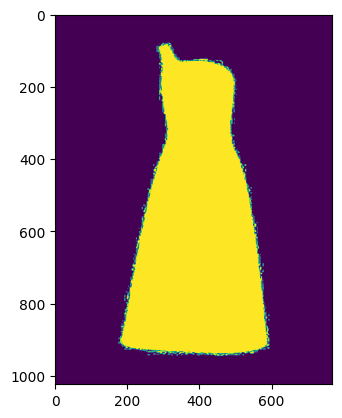

In [10]:
mask = sample["ref_mask"][0]
plt.imshow(mask)
plt.show()

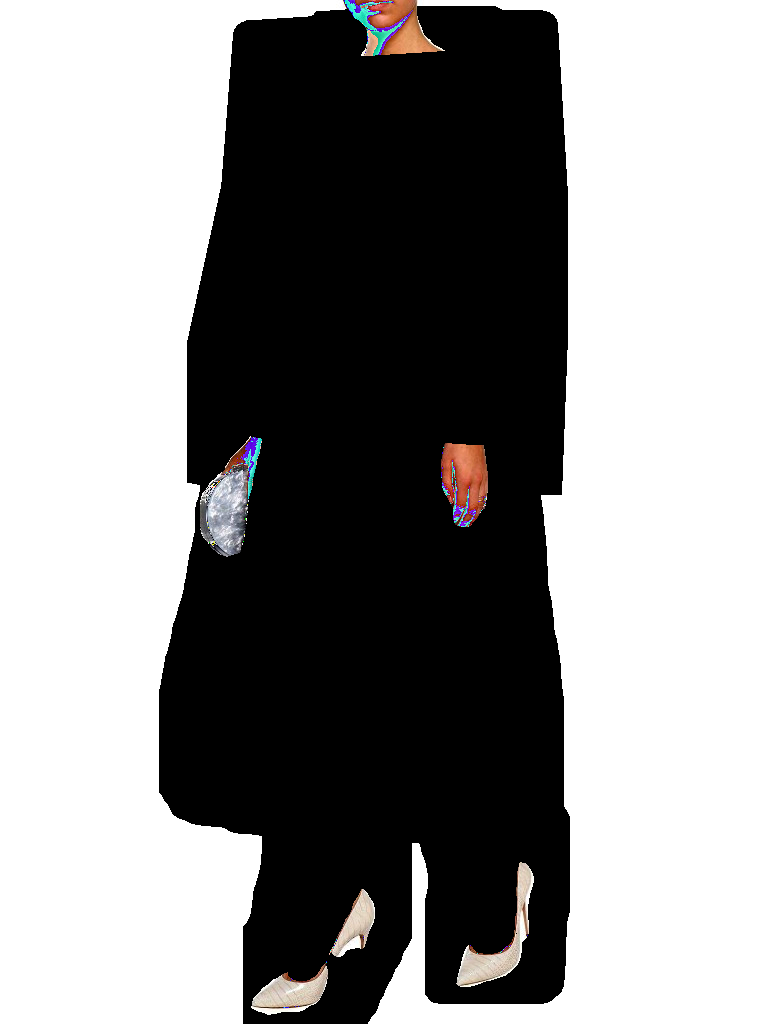

In [13]:
to_pil_image = ToPILImage()
img = to_pil_image(sample["m"][0])

# Display the image
img.show()

In [18]:
grayscale_transform = Grayscale(num_output_channels=1)
gray_tensor = grayscale_transform(sample["cloth"][0])

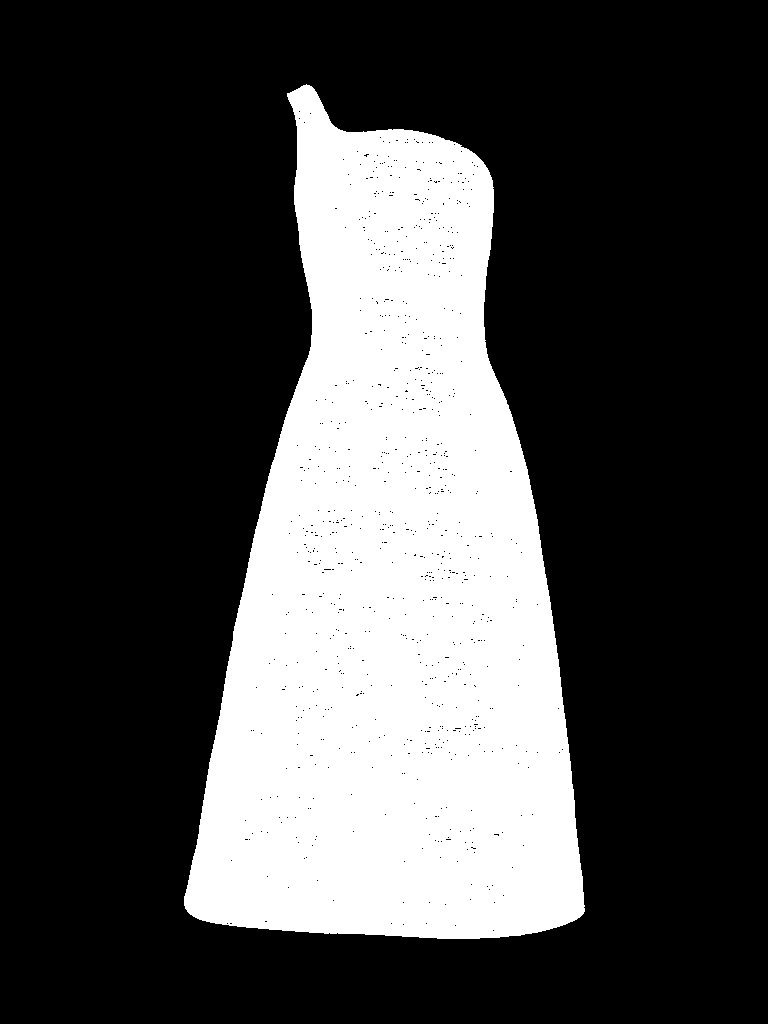

In [19]:
threshold = 0.5
mask_tensor = gray_tensor < threshold

# Convert the boolean mask back to an image for visualization
to_pil_image = ToPILImage()
mask_image = to_pil_image(mask_tensor.float())

# Display the mask
mask_image.show()

TypeError: Invalid shape (3, 256, 192) for image data

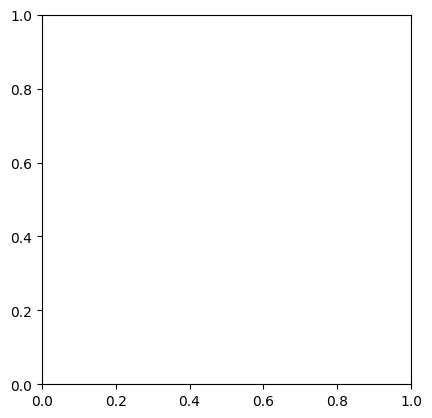

In [9]:
for key in ["cloth"]:
    plt.imshow(sample[key][0], interpolation='nearest')
    plt.show()